##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [78]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Leo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud 
from collections import Counter


In [80]:
train_data = pd.read_csv("./data/Train.csv", sep=',')
test_data = pd.read_csv("./data/Test.csv", sep=',')


In [81]:
# observe a data record
print("Train data first 5 items: \n", train_data.iloc[:5, :])
print("Test data first 5 items: \n", test_data.iloc[:5, :])


Train data first 5 items: 
    Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   

                                                text sentiment  
0   doctors hit campaign trail as race to medical...   neutral  
1   is anybody going to the radio station tomorro...  positive  
2   i just found out naruto didn't become the 5th...   neutral  
3   "prince george reservist who died saturday ju...   neutral  
4   season in the sun versi nirvana rancak gak..s...  positive  
Test data first 5 items: 
                    id                                               text
0  802217876644052000   @loogunda @poroshenko putin abducted ukrainia...
1  802425296955682000   if putin wanted to intervene all he would hav...
2  805664502515662000   @hillbuzz @gaypatriot elsewhere in progland.....
3  639928670103015000   any females copp

##### Split train and test data, then we separate the tweet text and the label (sentiment). 
##### The Train.csv dataset is further splited into: Training dataset, and validation dataset. The officially provided test dataset will be used for evaluating each model on Kaggle 
##### __url__ HERE
##### Responsibilities of each dataset:
###### train_data works as the training dataset for the models.
###### validation_data works as the validation dataset for evaluating then **tuning** the model parameters.
###### Finally the test_data would be used as the testing dataset for evaluating the performance of our tuned models on Kaggle.

In [94]:
#separating instance and label for Train
X_train = [x[0] for x in train_data[['text']].values]
y_train = [x[0] for x in train_data[['sentiment']].values]
X_test = [x[0] for x in test_data[["text"]].values]

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.75)

Now each row is a list of tuples with the vector_id (word_id in the vocabulary) and the number of times it repeated in that given instance (tweet).

In [84]:

test_s = ["What da' heck, why'd i get such an a? He gets a lil bit drunk. you are a yogurt, yo. Listen to me, you needs to stop. Stop!! Gets out of my room, Errors should never pass silently."]
tokenizer = Tokenizer( oov_token='<??>')
tokenizer.fit_on_texts(test_s)
print(tokenizer.word_index)


{'<??>': 1, 'a': 2, 'gets': 3, 'you': 4, 'to': 5, 'stop': 6, 'what': 7, "da'": 8, 'heck': 9, "why'd": 10, 'i': 11, 'get': 12, 'such': 13, 'an': 14, 'he': 15, 'lil': 16, 'bit': 17, 'drunk': 18, 'are': 19, 'yogurt': 20, 'yo': 21, 'listen': 22, 'me': 23, 'needs': 24, 'out': 25, 'of': 26, 'my': 27, 'room': 28, 'errors': 29, 'should': 30, 'never': 31, 'pass': 32, 'silently': 33}


As we can tell, Tokenizer does do some lemmatisation job such as remove the tail punctuations for you. However, it's does not do the job of the rest of lemmatisation.

## ==== Preprocessing Toolkit ====
__Creating NLP preprocessing functions for later use__

In [85]:
def lemmatise_words(words:list):
    lemmatiser = WordNetLemmatizer()
    return [lemmatiser.lemmatize(w) for w in words]


In [86]:
def tokenise(texts):
    tokenizer = Tokenizer(oov_token="<?>")
    tokenizer.fit_on_texts(texts)

In [87]:
def no_nonalpha(words:list):
    return [w for w in words if w.isalpha()]

In [88]:
def to_lower(words:list):
    return [w.lower() for w in words]

In [89]:
def no_stop(words:list):
    s = stopwords.words('english')
    return [w for w in words if w not in s]

In [90]:
def wrangle(data, alpha_only = True, lemmatised = True, stop_removed = True, display_first =  0, visual = False):
    wrangled_out = []
    original_words = []
    lemmatised_words = []
    stop_removed_words = []
    for record in data:
        words = np.array(record.split())
        # to lower
        words = to_lower(words)
        if display_first > 0:
            print("Lower case: \n",words)
        # remove non-alphabetical words
        if alpha_only:
            words = no_nonalpha(words)
            if display_first > 0:
                print("Alphabets only: \n",words)
            for w in words:
                original_words.append(w)
        # lemmatisation
        if lemmatised:
            words = lemmatise_words(words)
            if display_first > 0:
                print("Lemmatised: \n", words)
            for w in words:
                lemmatised_words.append(w)
        # Remove stop words
        if stop_removed:
            words = no_stop(words)
            if display_first > 0:
                print("Stop words removed: \n",words)
            for w in words:
                stop_removed_words.append(w)
        wrangled_out.append(words)
        display_first -= 1
    # visualise use word cloud
    if visual:
        # non-alpha removed
        cloud = WordCloud(max_words=120, max_font_size=40, background_color="white")
        cloud.generate(" ".join(original_words))
        plt.figure(figsize=(16,16),dpi = 150)
        plt.title("WordCloud showing training data after non-alphabet phrases removal.")
        plt.imshow(cloud, alpha=0.9)

        # lemmatised_words
        cloud = WordCloud(max_words=120, max_font_size=40, background_color="white")
        cloud.generate(" ".join(lemmatised_words))
        plt.figure(figsize=(16,16),dpi = 150)
        plt.title("WordCloud showing training data after non-alphabet phrases removal, and lemmatisation.")
        plt.imshow(cloud, alpha=0.9)

        # stop removed
        cloud = WordCloud(max_words=120, max_font_size=40, background_color="white")
        cloud.generate(" ".join(stop_removed_words))
        plt.figure(figsize=(16,16),dpi = 150)
        plt.title("WordCloud showing training data after non-alphabet phrases removal, lemmatisation, and stopwords removal (sequential).")
        plt.imshow(cloud, alpha=0.9)
            
    return wrangled_out



# Preprocessing

Lemmatisation is done as the first step since it regulate stop words to their original form, serving for the following procesesing jobs.

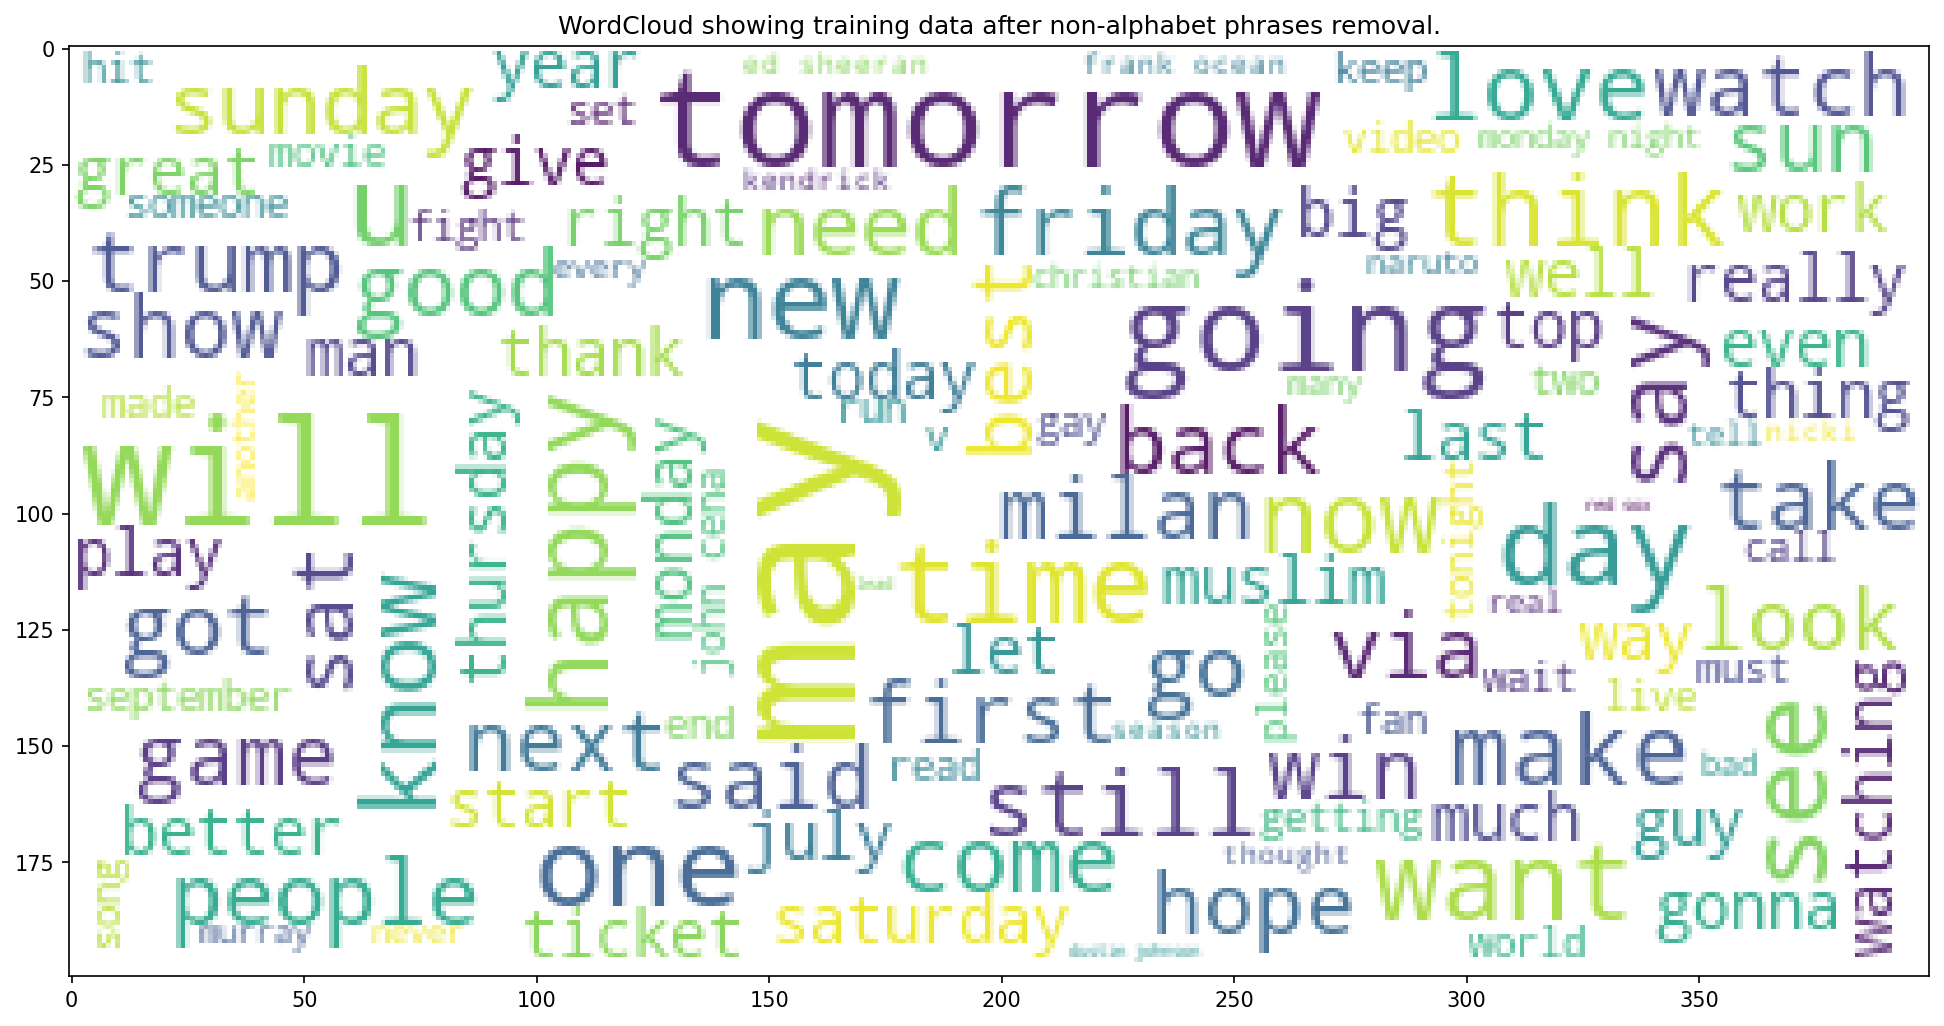

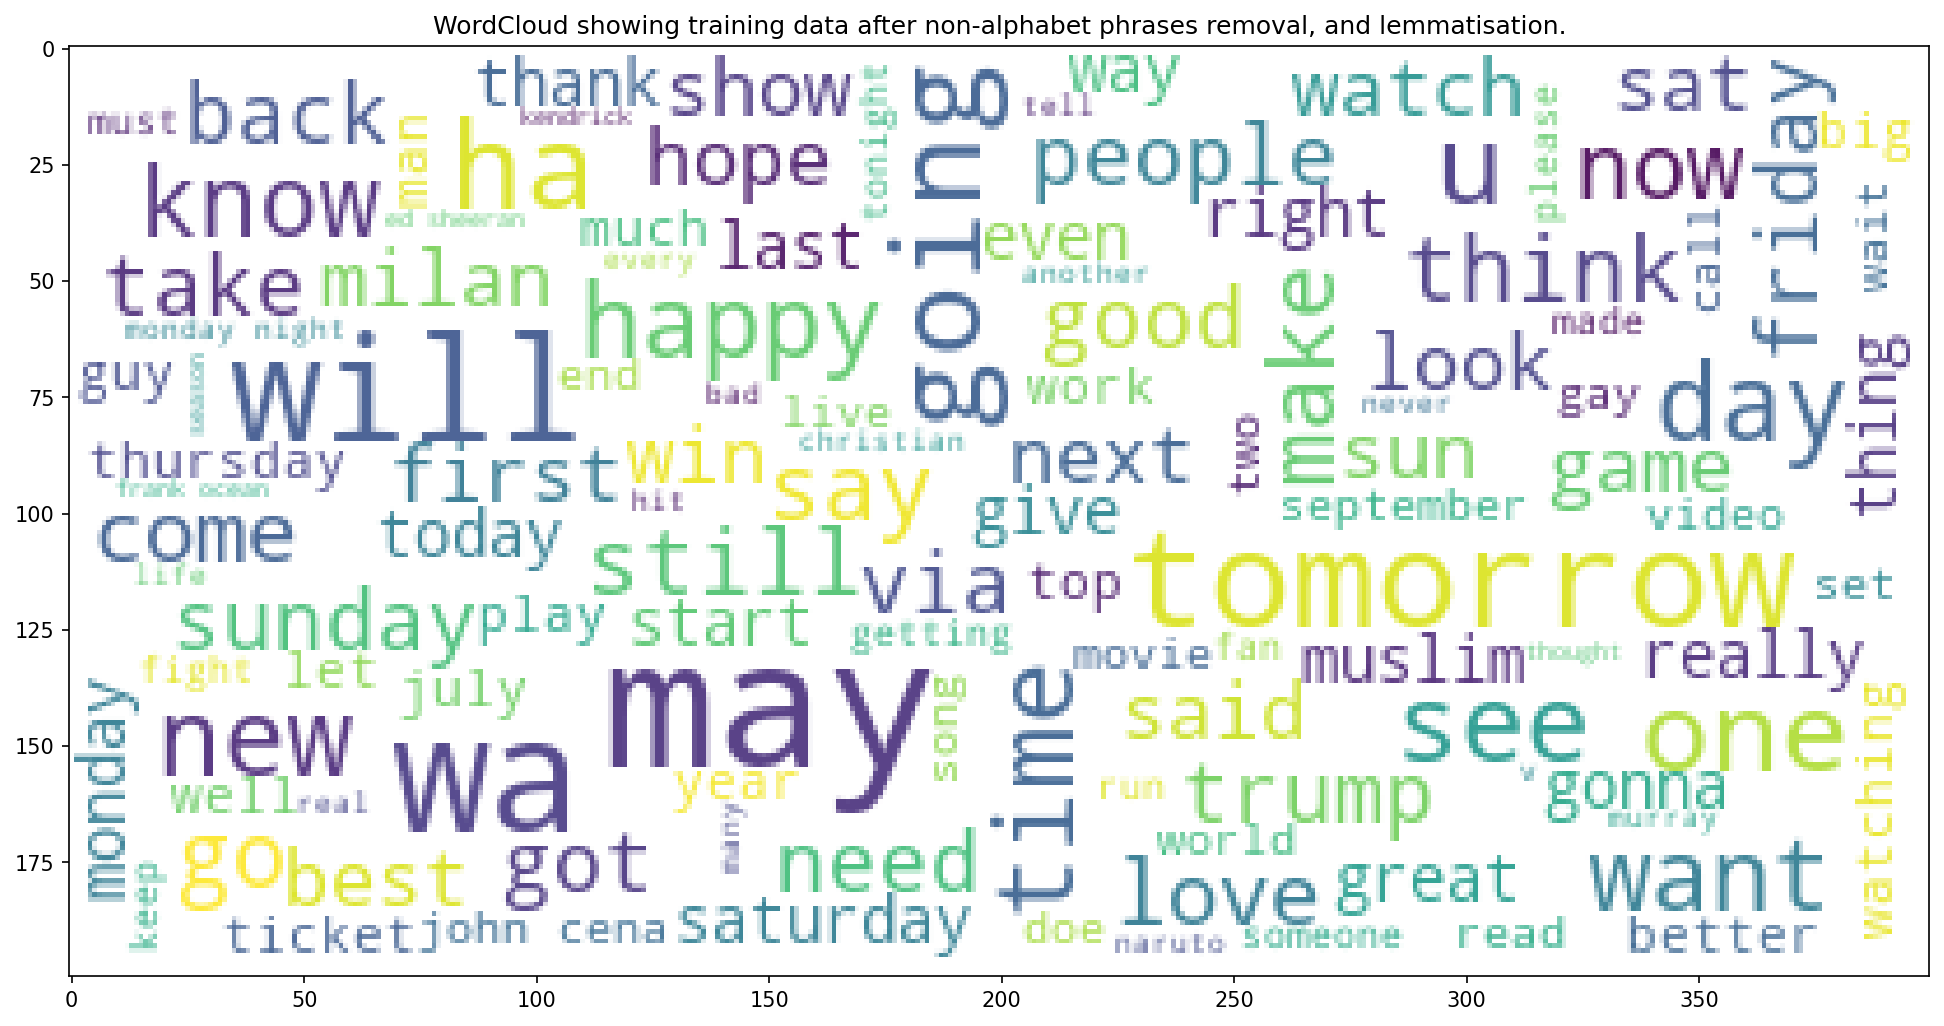

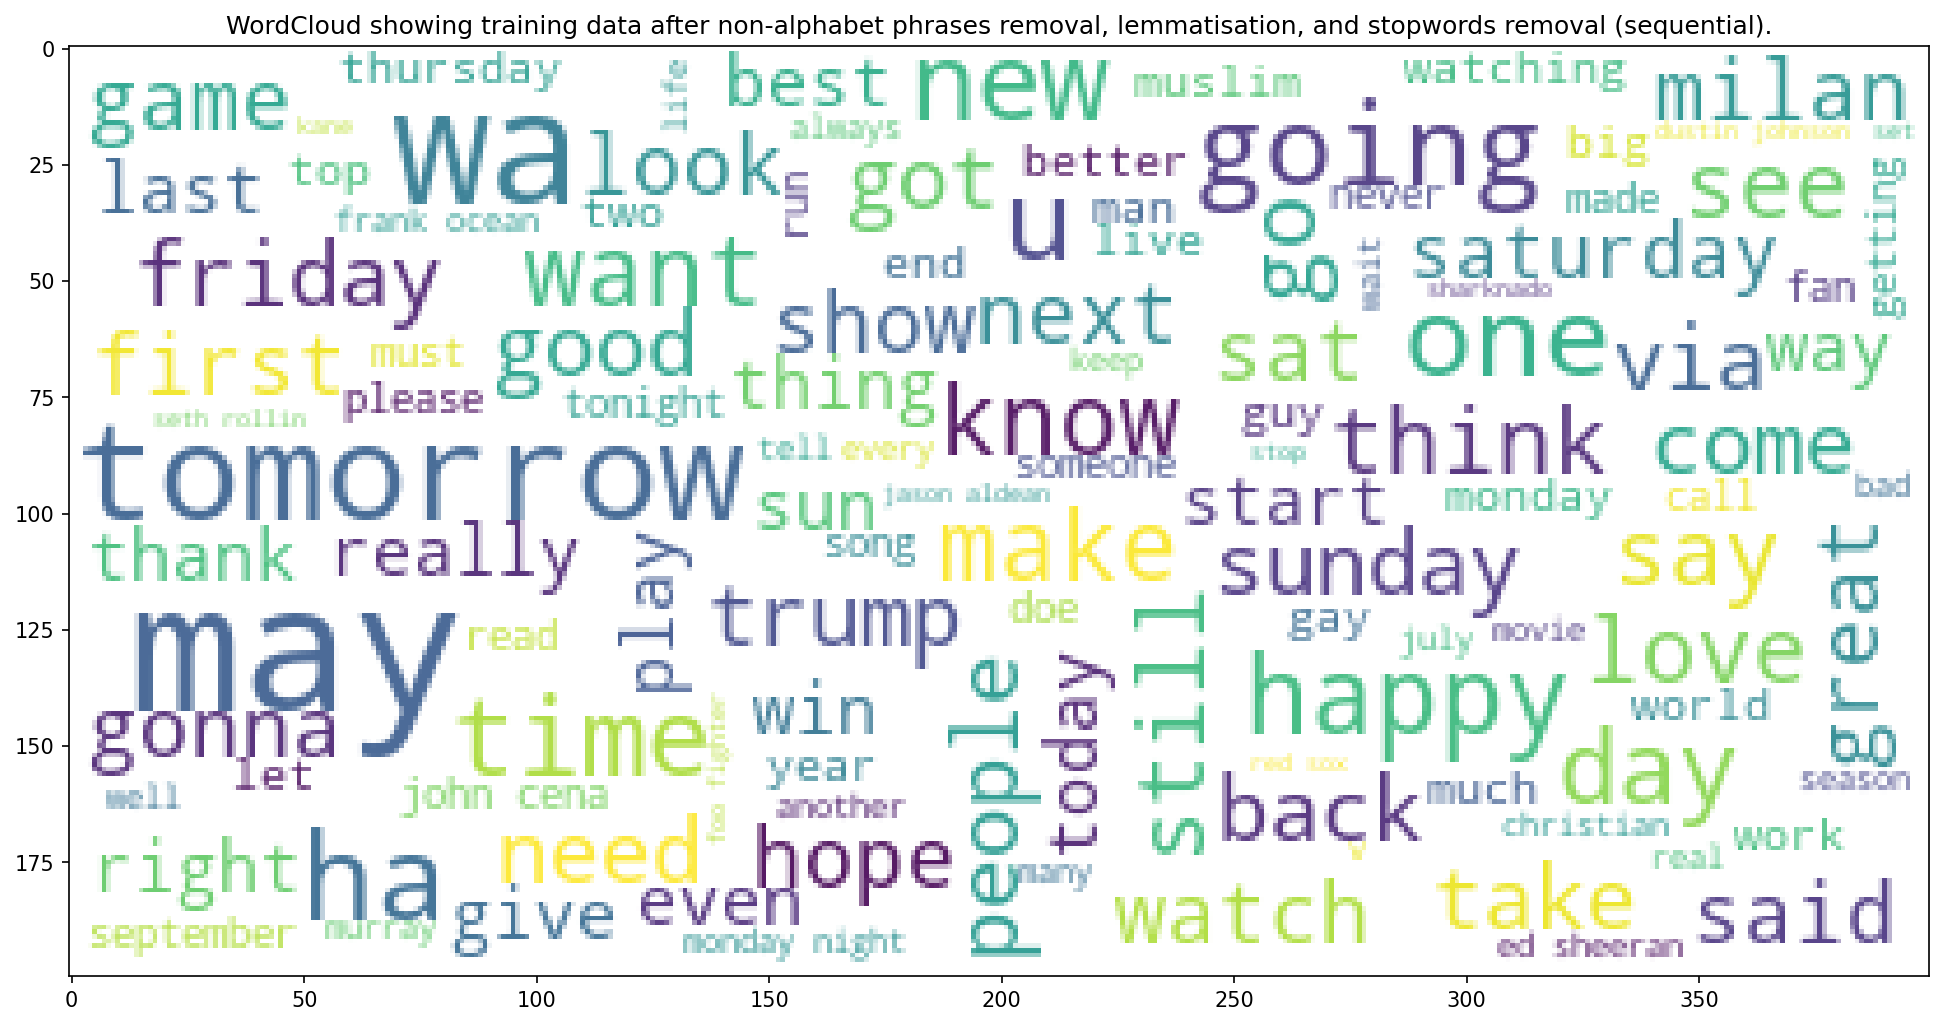

In [91]:
wrangled_train = wrangle(X_train, display_first=0, visual = True)

### __Apply same wrangling to validation set and test set__

In [95]:
wrangled_validation = wrangle(X_validation, display_first=0, visual = False)
wrangled_test = wrangle(X_test, display_first=0, visual=False)

__now fed the cleaned data into the TFIDF Vectorizer__

In [119]:
def get_tfidf_fit(dataset:list):
    flatten = []
    for s in dataset:
        flatten.append(" ".join(s))
    # print(flatten)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_fit = tfidf_vectorizer.fit(flatten)
    return tfidf_fit

def act_tfidf_fit(dataset:list, tfidf_fit):
    flatten = []
    for s in dataset:
        flatten.append(" ".join(s))
    return tfidf_fit.transform(flatten)

tfidf_fit = get_tfidf_fit(wrangled_train)

# tfidf to all 3 datasets
tfidf_train = act_tfidf_fit(wrangled_train, tfidf_fit)
tfidf_validation = act_tfidf_fit(wrangled_validation, tfidf_fit)
tfidf_test = act_tfidf_fit(wrangled_test, tfidf_fit)

N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True
OOB_SCORE = True


forest = RandomForestClassifier(
    n_estimators=N_ESTIMATOR, min_samples_leaf=MIN_SAMPLES_LEAF, bootstrap=BOOTSTRAP, oob_score=OOB_SCORE)
# forest.fit()


__Perform Randomforest with 0.25 cross validation__

In [120]:
N_ESTIMATOR = 500
MIN_SAMPLES_LEAF = 2
BOOTSTRAP = True
OOB_SCORE = True
CV = 4


In [124]:
forest = RandomForestClassifier(
    n_estimators=N_ESTIMATOR, min_samples_leaf=MIN_SAMPLES_LEAF, bootstrap=BOOTSTRAP, oob_score=OOB_SCORE)

In [125]:
forest.fit()

True

__Model Tuning__

In [ ]:
from sklearn.model_selection import GridSearchCV
